In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, utils

In [2]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

Files already downloaded and verified


In [53]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P100-PCIE-16GB


In [3]:
def latent_space_vectors(size): #size is the number of samples in a batch
    return torch.randn(size, 100, 1, 1)#.to(device)

def real_data_target(size):
    return (torch.ones(size)).to(device)

def fake_data_target(size):
    return (torch.zeros(size)).to(device)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convT1 = nn.ConvTranspose2d(100, 256, kernel_size = 4, stride = 1, padding = 0)
        self.batch_norm1 = nn.BatchNorm2d(256)
        
        self.convT1_labels = nn.ConvTranspose2d(10, 256, kernel_size = 4, stride = 1, padding = 0)
        self.batch_norm1_labels = nn.BatchNorm2d(256)
        
        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.convT4 = nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1)
        
    def forward(self, x, y):
        x = self.convT1(x)
        x = F.relu(self.batch_norm1(x))
        
        y = self.convT1_labels(y.view(100, 10, 1, 1))
        y = F.relu(self.batch_norm1_labels(y))
        
        x = torch.cat((x,y), 1)
        
        x = self.convT2(x)
        x = F.relu(self.batch_norm2(x))
        x = self.convT3(x)
        x = F.relu(self.batch_norm3(x))
        x = self.convT4(x)
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1)
        
        self.conv1_labels = nn.Conv2d(10, 32, kernel_size = 4, stride = 2, padding = 1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 2, stride = 1, padding = 0) #4,1,0
        
    def forward(self, x, y):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        y = self.conv1_labels(y)
        y = F.leaky_relu(y, 0.2)
        x = torch.cat((x, y), 1)
        x = self.conv2(x)
        x = F.leaky_relu(self.batch_norm1(x), 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(self.batch_norm2(x), 0.2)
        x = self.conv4(x)
        x = F.leaky_relu(self.batch_norm3(x), 0.2)
        x = self.conv5(x)
        x = torch.sigmoid(x)
        return x

In [0]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)
loss_function = torch.nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [0]:
def one_hot_encoder(labels, num_labels):
    batch_size = len(labels)
    one_hot_labels = torch.zeros([batch_size, num_labels])
    for i in range(batch_size):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

In [0]:
def train_generator(fake_image, fake_image_labels):
    generator.zero_grad()
    
    prediction_fake_image = discriminator.forward(fake_image, fake_image_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    optimizer_generator.step()
    
    return loss_fake_image

In [0]:
def train_discriminator(real_image, fake_image, real_labels, fake_labels):
    discriminator.zero_grad()
    
    #train on real images
    prediction_real_image = discriminator.forward(real_image, real_labels).view(100)
    loss_real_image = loss_function(prediction_real_image, real_data_target(prediction_real_image.size(0)))
    loss_real_image.backward()
    
    #train on fake images
    prediction_fake_image = discriminator.forward(fake_image, fake_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, fake_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real_image, prediction_fake_image

In [ ]:
EPOCHS = 500
losses_D = np.zeros([500])
losses_G = np.zeros([500])

for i in range(EPOCHS):
    for real_batch, labels in tqdm(train_batch):
        
        real_image = real_batch.to(device)#real image batch 100
        
        real_image_labels_d = torch.zeros(100, 10, 32, 32).to(device)#into discriminator
        fake_image_labels_d = torch.zeros(100, 10, 32, 32).to(device)#into discriminator
        fake_image_labels_g = torch.zeros(100, 10).to(device)#into generator
        
        for j in range(100):
            real_image_labels_d[j][labels[j]] = 1
            fake_image_labels_d[j][labels[j]] = 1
            fake_image_labels_g[j][labels[j]] = 1
            
            
        fake_image = generator.forward(latent_space_vectors(100), fake_image_labels_g)
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_image, fake_image, real_image_labels_d, fake_image_labels_d)
        
        
        
        fake_image = generator.forward(latent_space_vectors(100), fake_image_labels_g)
        g_error = train_generator(fake_image, fake_image_labels_d)
    losses_D[i] = d_error
    losses_G[i] = g_error
    utils.save_image(fake_image, os.path.join('/content/gdrive/My Drive/Colab Notebooks', str(i)+str('.png')))
    print('Epoch = '+ str(i) + " Discriminator loss = " + str(d_error.data.cpu().numpy()) + " Generator loss = " + str(g_error.data.cpu().numpy()))

In [ ]:
model_generator = 'generator.pt'
model_discriminator = 'discriminator.pt'
loss_D = F"/content/gdrive/My Drive/Colab Notebooks/loss_D"
loss_G = F"/content/gdrive/My Drive/Colab Notebooks/loss_G"
path_generator = F"/content/gdrive/My Drive/Colab Notebooks/{model_generator}"
path_discriminator = F"/content/gdrive/My Drive/Colab Notebooks/{model_discriminator}"
torch.save(generator.state_dict(), path_generator)
torch.save(discriminator.state_dict(), path_discriminator)
torch.save(losses_D, loss_D)
torch.save(losses_G, loss_G)

In [ ]:
utils.save_image(fake_image, F'/content/gdrive/My Drive/Colab Notebooks/fake.png')
img = cv2.imread('fake.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)
plt.imshow(img)
plt.show()

In [0]:
utils.save_image(real_image, F'/content/gdrive/My Drive/Colab Notebooks/real.png')
img = cv2.imread('real.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)
plt.imshow(img)
plt.show()

In [0]:
def plot_loss(losses_D):
    fig = plt.gcf()
    fig.set_size_inches(20.5, 8)
    x_label = np.linspace(0, 500 , num = 500)
    y_label = np.reshape(losses_D, [500,1])
    plt.plot(x_label, y_label)
    plt.show()

plot_loss(losses_D)
plot_loss(losses_G)

<h1>Testing</h1>
<h3>Images are too small to visualize but most of them are conditionally correct.</h3>

In [5]:
for real_image, real_labels in train_batch:
    break
    
fake_image_labels_g = torch.zeros(100, 10)
for i in range(100):
    fake_image_labels_g[i][real_labels[i]] = 1

In [6]:
model = Generator()
model.load_state_dict(torch.load('generator.pt'))
fake_samples = model.forward(latent_space_vectors(100), fake_image_labels_g)

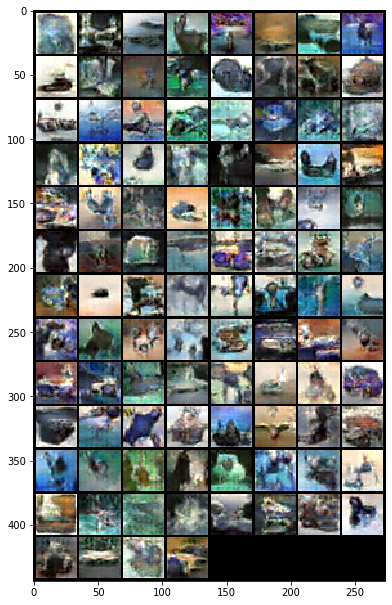

In [54]:
utils.save_image(m, F'/home/aditya/Data/fake.png')
img = cv2.imread('fake.png')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.imshow(img)
plt.show()

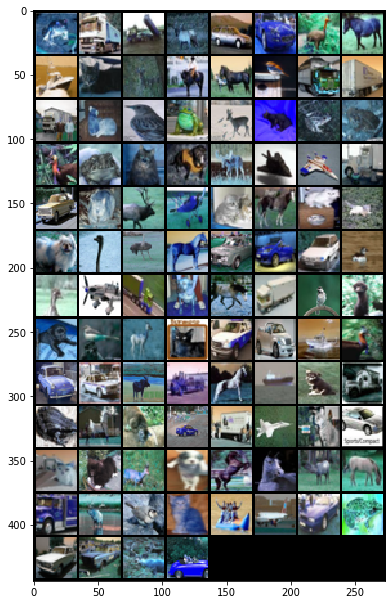

In [55]:
utils.save_image(w, F'/home/aditya/Data/real.png')
img = cv2.imread('real.png')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.imshow(img)
plt.show()